In [1]:
import pandas as pd
import pickle
import re
import spacy
nlp = spacy.load("en_core_web_sm")
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
from sklearn.utils.extmath import randomized_svd
import re
from nltk.tokenize import word_tokenize, sent_tokenize
from Preprocessing import preprocess_transcript

In [2]:
df = pd.read_pickle("/Users/akshaykekuda/Desktop/CSR-SA/attention_model/ScoringDetail_viw_all_subscore.p")
df = df.sort_values(by= ['RecordingDate', 'QGroupSequence', 'QuestionSequence']).copy()
cols = ['QGroupSequence', 'QGroupName','InteractionIdKey', 'QuestionSequence', 'QuestionText', 'QuestionType', 
        'QuestionPromptType', 'QuestionWeight', 'QuestionMin', 'QuestionMax', 'AnswerScore', 'RawAnswer', 'DisplayAnswer', 
        'UserComments']
calls_df = df[(df.QuestionnaireName == 'Call Interaction')].copy()
q_df = calls_df[cols]
temp = q_df[0:10]
temp = temp.reset_index(drop=True)
q_text =[]
for index, row in temp.iterrows():
    q_text.append(row['QuestionText'])

In [3]:
score_df = pd.DataFrame()

score_df['WorkgroupQueue'] = calls_df.WorkgroupQueue[::10]
score_df['RecordingDate'] = calls_df.RecordingDate[::10]
score_df['CombinedPercentileScore'] = calls_df.CombinedPercentileScore[::10].astype(float).round(2)
score_df['Category'] = (score_df['CombinedPercentileScore'] > 75).apply(lambda x:int(x))
score_df.index = calls_df.InteractionIdKey[::10]
score_comment_df = score_df.copy()
for i in range(10):
        criteria = q_text[i]
        q_max = int(calls_df.QuestionMax.iloc[i])
        score_df[criteria] = (calls_df.AnswerScore[i::10]).values
        score_df[criteria] = score_df[criteria].apply(lambda x: 0 if x >= q_max else 1) #used as binary class
        # score_df[criteria] = score_df[criteria].apply(lambda x: 1 if x >= q_max else 0) #used as binary class
        score_df[criteria + ' Feedback'] = (calls_df.UserComments[i::10]).values
    
score_df = score_df.loc[~score_df.index.duplicated(keep='last')]

In [4]:
score_df[score_df['RecordingDate'] >= '2021-05-18'].WorkgroupQueue.value_counts()

Customer Service    1353
Sales               1013
                      52
Agency Servicing      12
CSD Chat Mobile        8
Escalation             3
CSD Email              3
Sales Chat             1
Sales Cancels          1
Name: WorkgroupQueue, dtype: int64

In [5]:
import os
score_cols = score_df.columns.to_list()
dir = "/Users/akshaykekuda/Desktop/CSR-SA/manual_score_transcriptions/output_dual/output"
df = pd.DataFrame(columns=(['csr_text', 'cust_text', 'csr_file_name', 'cust_file_name']) + score_cols )
for file in os.listdir(dir):
    if file.endswith('.txt'):
        file_loc = dir + '/' + file
        f = open(file_loc, 'r')
        tscpt = f.read()
        f.close()
        arr = file.split("_")
        speaker = arr[0]
        id = arr[2].split('.')[0]
        if id in score_df.index:
            if speaker=='l':
                df.loc[id, ['cust_text', 'cust_file_name']] = [tscpt, file_loc]
            if speaker == 'r':
                df.loc[id, ['csr_text', 'csr_file_name']] = [tscpt, file_loc]
            df.loc[id, score_cols] = score_df.loc[id]                

IndexError: list index out of range

In [5]:
import os
score_cols = score_df.columns.to_list()
dir = r"/Users/akshaykekuda/Desktop/CSR-SA/manual_score_transcriptions/output_dual/output"
df = pd.DataFrame(columns=(['text', 'file_name']) + score_cols )
for file in os.listdir(dir):
    if file.endswith('.txt'):
        file_loc = dir + '/' + file
        f = open(file_loc, 'r')
        tscpt = f.read()
        f.close()
        arr = file.split("_")
        speaker = arr[0]
        id = arr[1].split('.')[0]
        if id in score_df.index:
            df.loc[id, ['text', 'file_name']] = [tscpt, file_loc]
            df.loc[id, score_cols] = score_df.loc[id]                

In [6]:
df = df.dropna()

In [12]:
feeback_str = [criterion+" Feedback" for criterion in q_text]
df[feeback_str] = df[feeback_str].applymap(lambda x: re.sub('[^A-Za-z0-9\.\' ]', '', x.lower()))
noun_phrase_str = [criterion + ' nounphrases' for criterion in q_text]
docs = nlp.pipe(df[feeback_str])

In [47]:
def fun(series):
    docs = nlp.pipe(series, batch_size=64)
    m = map(lambda x: [nounphrase.text for nounphrase in x.noun_chunks], docs)
    return [comment_np for comment_np in m]

In [48]:
df[feeback_str] = df[feeback_str].apply(lambda x: fun(x))

In [50]:
df['text'].apply(lambda x: fun(x))

KeyboardInterrupt: 

In [177]:
criterion='Cross Selling'
k=20

In [178]:
vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False, stop_words='english')

In [179]:
df

,text,file_name,WorkgroupQueue,RecordingDate,CombinedPercentileScore,Category,Greeting,Greeting Feedback,Professionalism,Professionalism Feedback,...,Creates Incentive,Creates Incentive Feedback,Product Knowledge,Product Knowledge Feedback,Education,Education Feedback,Documentation,Documentation Feedback,Processes,Processes Feedback
100183715530210106,Thanks for calling safe i how may help you yes...,/Users/akshaykekuda/Desktop/CSR-SA/manual_scor...,Sales,2021-01-06 14:01:36.900000,87.18,1,0,"[great job, the call, time]",0,"[great job, imediate assistance]",...,0,"[great job, the sale, incentives, the sale]",0,"[great job, additional drivers, product knowle...",0,"[great job, the mvr disclosure, coverages]",0,[notes],0,"[great job, all customer verification, all dri..."
200112412040210111,Hello i my name is michelle my name is michell...,/Users/akshaykekuda/Desktop/CSR-SA/manual_scor...,Customer Service,2021-01-11 12:14:36.340000,94.87,1,0,"[csr, herself, greeting]",0,"[csr, a great tone, maner, she]",...,0,"[csr, the customer, the correct information]",0,[product expectations],0,[customers],0,"[all the information, the notes]",0,"[csr, the correct procedures, the interaction]"
300135515340210201,Thank you for calling safe auto my name is jos...,/Users/akshaykekuda/Desktop/CSR-SA/manual_scor...,Customer Service,2021-02-01 13:03:41.867000,87.18,1,0,"[csr, himself, greeting]",0,"[csr, a great tone, maner, he]",...,0,"[csr, the customer, the correct information]",0,[product expectation],1,"[csr, forms]",0,"[all the information, the notes]",0,"[csr, the correct procedures, the interaction]"
100159553380200430,Hello.\nSingle concept so this this sounds lik...,/Users/akshaykekuda/Desktop/CSR-SA/manual_scor...,Sales,2020-04-30 12:06:34.523000,46.15,0,0,"[good job, the call, a timely matter, yourself...",0,[the customer],...,1,"[applicable discounts, the sale]",1,[the underwritting questions],1,"[good job, client, mvr report confirmation num...",0,"[notation, this, a sales calls]",1,"[salvador, mind, we, anything, that, the rate,..."
300189092440210329,But you take your sister.\nThank you for calli...,/Users/akshaykekuda/Desktop/CSR-SA/manual_scor...,Customer Service,2021-03-29 10:30:49.837000,66.67,0,0,"[csr, himself, greeting]",0,"[csr, a great tone, maner, he]",...,0,"[csr, the customer, the correct information]",0,[product expectations],1,"[csr, forms, wrong information]",1,"[csr, no notes, the policy]",1,"[csr, the wrong wrap, code]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200157147230210309,Thank you for calling safe auto the slot how c...,/Users/akshaykekuda/Desktop/CSR-SA/manual_scor...,Customer Service,2021-03-09 11:34:18.580000,100.0,1,0,"[great greeting, yourself, company]",0,[rep],...,0,"[msi rep, all question]",0,[great performance],0,[great education],0,[great notes],0,"[step, step]"
2001224242A0200702,Thank you for calling safe auto my name is cyl...,/Users/akshaykekuda/Desktop/CSR-SA/manual_scor...,Sales,2020-07-02 18:09:37.267000,58.97,0,0,"[we, a good job, ourselves, the company, the b...",0,"[the beginning, the call, we]",...,1,"[we, applicable discounts, ho, nbt]",0,"[we, accurate quote, customer needs]",1,"[we, the optional not selected coverages, this...",0,[this quote],1,"[we, coverages.did, ssn verification]"
200181718320191210,Thank you for calling safe auto speaking.\nA p...,/Users/akshaykekuda/Desktop/CSR-SA/manual_scor...,Sales,2019-12-10 09:49:57.257000,46.15,0,0,"[we, a good job, ourselves, the company, the b...",0,"[the beginning, the call, we]",...,1,"[we, discount, customer, ho, we, proof, reason...",1,"[uwq, we, payment, card decline]",1,"[cc, we, the information, that day]",0,"[notes, this policy attempt, purchase]",1,"[customer, ssn, driver, ad, a very important i..."
200125639050210417,Favorite calling safe auto my name is paddy ho...,/Users/akshaykekuda/Desktop/CSR-SA/manual_scor...,Sales,2021-04-17 12:04:56.430000,100.0,1,0,"[we, timely manner, good

In [200]:
y = ['Cross Selling', 'Creates Incentive', 'Product Knowledge', 'Education', 'Processes', 'Greeting', 'Professionalism', 'Confidence',  'Retention',
                        'Documentation']
best_df = pd.DataFrame()
top_feature_count = 20
for criterion in y:
    good_indices = np.where(df[criterion] == 1)
    vect_representation = vectorizer.fit_transform(df[criterion + ' Feedback'])
    X = vect_representation.todense()
    tfidf = TfidfTransformer()
    Y = tfidf.fit_transform(X[good_indices[0], :]).todense()
    tf_idf_df = pd.DataFrame(Y.T, index=vectorizer.get_feature_names_out())
    top_feature_count = k
    top_comments = tf_idf_df.mean(axis=1).sort_values(ascending=False)[:top_feature_count]
    best_df[criterion + ' Top comments']=top_comments.index.tolist()
# feature_indices = [i for i, name in enumerate(vectorizer.get_feature_names_out()) if name in top_comments]
# count_vecs = X[:, feature_indices]
# count_vecs = 1 * (count_vecs > 0)
# df[criterion + " fbk_vector"] = count_vecs.tolist()

/opt/homebrew/Caskroom/miniforge/base/envs/m1_optim/lib/python3.9/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/m1_optim/lib/python3.9/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/m1_optim/lib/python3.9/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https:/

In [201]:
best_df

,Cross Selling Top comments,Creates Incentive Top comments,Product Knowledge Top comments,Education Top comments,Processes Top comments,Greeting Top comments,Professionalism Top comments,Confidence Top comments,Retention Top comments,Documentation Top comments
0,sell,the sale,customer,customer,customer,the call,the call,dead air,customer,csr
1,recreational vehicles,incentive,itc,the coverages,state,csr,customer,over 20 seconds,the customer,the notes
2,any recreational vehicles,good job,partner companies,good job,csr,agent,the customer,a lapse,other carriers,the policy
3,customer,sale,partner carriers,change,all driver information,the customer,agent,the call,a quote,notes
4,renters insurance,an incentive,the best rate,coverages,mind,insurance,csr,csr,policy,complete notes
5,renters,proof,insurance,all coverages,the rate,proof,the quote,death air,enough commitment,all the information
6,good job,applicable discounts,customers,subject,all customer information,8 seconds,insurance,the customer,price,all information
7,this call,insurance,other carriers,mvr report,vehicle usage,the quote,voice,customer,the policy,the call
8,no cross selling,benefit,rates,the customer,code,the company,proof,information,opinion,customer
9,renters homeowners,customer,uwq,mobile app,good job,intro,a great tone,the information,a better rate,no notes


In [202]:
y = ['Cross Selling', 'Creates Incentive', 'Product Knowledge', 'Education', 'Processes', 'Greeting', 'Professionalism', 'Confidence',  'Retention',
                        'Documentation']
best_df = pd.DataFrame()
top_feature_count = 20
for criterion in y:
    good_indices = np.where(df[criterion] == 0)
    vect_representation = vectorizer.fit_transform(df[criterion + ' Feedback'])
    X = vect_representation.todense()
    tfidf = TfidfTransformer()
    Y = tfidf.fit_transform(X[good_indices[0], :]).todense()
    tf_idf_df = pd.DataFrame(Y.T, index=vectorizer.get_feature_names_out())
    top_feature_count = k
    top_comments = tf_idf_df.mean(axis=1).sort_values(ascending=False)[:top_feature_count]
    best_df[criterion + ' Top comments']=top_comments.index.tolist()
# feature_indices = [i for i, name in enumerate(vectorizer.get_feature_names_out()) if name in top_comments]
# count_vecs = X[:, feature_indices]
# count_vecs = 1 * (count_vecs > 0)
# df[criterion + " fbk_vector"] = count_vecs.tolist()

/opt/homebrew/Caskroom/miniforge/base/envs/m1_optim/lib/python3.9/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/m1_optim/lib/python3.9/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/m1_optim/lib/python3.9/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https:/

In [203]:
best_df

,Cross Selling Top comments,Creates Incentive Top comments,Product Knowledge Top comments,Education Top comments,Processes Top comments,Greeting Top comments,Professionalism Top comments,Confidence Top comments,Retention Top comments,Documentation Top comments
0,sell,csr,product expectations,customer need,csr,time,the call,the call,good job,notes
1,recreational vehicles,the correct information,good proper knowledge,customers,the interaction,the call,customer,information,a solution,this type
2,good job,the sale,product knowledge expectation,the customers,all driver information,good job,good job,a good tone,proper resolution,a sales call
3,opportunity,the call,all questions,the proper information,all customer verification,csr,the beginning,the customer,need,the notes
4,no area,customer,product knowledge,coverages,great job,greeting,professional courteous polite,the information,the call,this case
5,renters homeowners,the customer,good product knowledge,customer,the call,timely manner,the customer,csr,needs,a specific statement
6,great job,good customer service,all available resources,good job,the correct procedure,the company,a good active listening,ownership,reason,accurate and proper documentation
7,the call,incentives,customer,the mvr disclosure,the correct procedures,a timely manner,csr,good job,the customer,a note
8,the reason,good job,good show,great job,the proper procedure,great job,great job,voice,the customers,no notation
9,renters,great job,additional drivers,the coverages,good job,a good job,imediate assistance,great job,customer,this quote


In [186]:
best_df

,sell,recreational vehicles,any recreational vehicles,customer,renters insurance,renters,good job,this call,no cross selling,renters homeowners,the customer,forever car,those products,benefit,rec vehicles,car,no attempt,the call,great job,any additional services


In [166]:
top_comments = tf_idf_df.mean(axis=1).sort_values(ascending=False)[:100]
top_comments

the sale         0.106410
incentive        0.086010
good job         0.074616
sale             0.074366
an incentive     0.070355
                   ...   
lynette          0.002039
rates            0.002037
no need          0.002032
ronald           0.001997
excellent job    0.001975
Length: 100, dtype: float64

In [95]:
vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False, stop_words='english')
good_indices = np.where(df['Cross Selling']>0)
vect_representation = vectorizer.fit_transform(df['Cross Selling Feedback'])
X = vect_representation.todense()
tfidf = TfidfTransformer()
Y = tfidf.fit_transform(X[good_indices[0], :]).todense()
tf_idf_df = pd.DataFrame(Y.T, index=vectorizer.get_feature_names_out()) 
top_feature_count = 20
top_comments = tf_idf_df.mean(axis =1).sort_values(ascending=False)[:top_feature_count]
print(top_comments)
feature_indices = [i for i, name in enumerate(vectorizer.get_feature_names_out()) if name in top_comments]
comment_target= X[:, feature_indices]

sell                         0.085479
recreational vehicles        0.071077
any recreational vehicles    0.069841
customer                     0.063642
renters insurance            0.059255
renters                      0.052107
good job                     0.048509
this call                    0.044022
no cross selling             0.035412
renters homeowners           0.034348
the customer                 0.033788
forever car                  0.031616
those products               0.028367
benefit                      0.026633
rec vehicles                 0.023426
car                          0.022762
no attempt                   0.022428
the call                     0.021995
great job                    0.021975
any additional services      0.019833
dtype: float64


/opt/homebrew/Caskroom/miniforge/base/envs/m1_optim/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/m1_optim/lib/python3.9/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/m1_optim/lib/python3.9/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more info

In [133]:
df

,text,file_name,WorkgroupQueue,RecordingDate,CombinedPercentileScore,Category,Greeting,Greeting Feedback,Professionalism,Professionalism Feedback,...,Creates Incentive Feedback,Product Knowledge,Product Knowledge Feedback,Education,Education Feedback,Documentation,Documentation Feedback,Processes,Processes Feedback,cross selling feedback target
100183715530210106,Thanks for calling safe i how may help you yes...,/Users/akshaykekuda/Desktop/CSR-SA/manual_scor...,Sales,2021-01-06 14:01:36.900000,87.18,1,0,"[great job, the call, time]",0,"[great job, imediate assistance]",...,"[great job, the sale, incentives, the sale]",0,"[great job, additional drivers, product knowle...",0,"[great job, the mvr disclosure, coverages]",0,[notes],0,"[great job, all customer verification, all dri...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."
200112412040210111,Hello i my name is michelle my name is michell...,/Users/akshaykekuda/Desktop/CSR-SA/manual_scor...,Customer Service,2021-01-11 12:14:36.340000,94.87,1,0,"[csr, herself, greeting]",0,"[csr, a great tone, maner, she]",...,"[csr, the customer, the correct information]",0,[product expectations],0,[customers],0,"[all the information, the notes]",0,"[csr, the correct procedures, the interaction]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
300135515340210201,Thank you for calling safe auto my name is jos...,/Users/akshaykekuda/Desktop/CSR-SA/manual_scor...,Customer Service,2021-02-01 13:03:41.867000,87.18,1,0,"[csr, himself, greeting]",0,"[csr, a great tone, maner, he]",...,"[csr, the customer, the correct information]",0,[product expectation],1,"[csr, forms]",0,"[all the information, the notes]",0,"[csr, the correct procedures, the interaction]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
100159553380200430,Hello.\nSingle concept so this this sounds lik...,/Users/akshaykekuda/Desktop/CSR-SA/manual_scor...,Sales,2020-04-30 12:06:34.523000,46.15,0,0,"[good job, the call, a timely matter, yourself...",0,[the customer],...,"[applicable discounts, the sale]",1,[the underwritting questions],1,"[good job, client, mvr report confirmation num...",0,"[notation, this, a sales calls]",1,"[salvador, mind, we, anything, that, the rate,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
300189092440210329,But you take your sister.\nThank you for calli...,/Users/akshaykekuda/Desktop/CSR-SA/manual_scor...,Customer Service,2021-03-29 10:30:49.837000,66.67,0,0,"[csr, himself, greeting]",0,"[csr, a great tone, maner, he]",...,"[csr, the customer, the correct information]",0,[product expectations],1,"[csr, forms, wrong information]",1,"[csr, no notes, the policy]",1,"[csr, the wrong wrap, code]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200157147230210309,Thank you for calling safe auto the slot how c...,/Users/akshaykekuda/Desktop/CSR-SA/manual_scor...,Customer Service,2021-03-09 11:34:18.580000,100.0,1,0,"[great greeting, yourself, company]",0,[rep],...,"[msi rep, all question]",0,[great performance],0,[great education],0,[great notes],0,"[step, step]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2001224242A0200702,Thank you for calling safe auto my name is cyl...,/Users/akshaykekuda/Desktop/CSR-SA/manual_scor...,Sales,2020-07-02 18:09:37.267000,58.97,0,0,"[we, a good job, ourselves, the company, the b...",0,"[the beginning, the call, we]",...,"[we, applicable discounts, ho, nbt]",0,"[we, accurate quote, customer needs]",1,"[we, the optional not selected coverages, this...",0,[this quote],1,"[we, coverages.did, ssn verification]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, ..."
200181718320191210,Thank you for calling safe auto speaking.\nA p...,/Users/akshaykekuda/Desktop/CSR-SA/manual_scor...,Sales,2019-12-10 09:49:57.257000,46.15,0,0,"[we, a good job, ourselves, the company, the b...",0,"[the beginning, the call, we]",...,"[we, discount, customer, ho, we, proof, reason...",1

## Noun Phrases from comments

In [291]:
phrases = pd.DataFrame(columns = ['comment', 'nounphrases'])
phrases['comment'] = score_comment_df['Cross Selling'].dropna()
phrases['comment'] = phrases['comment'].apply(lambda x: re.sub('[^A-Za-z0-9\.\' ]', '', x.lower()))
phrases['nounphrases'] = phrases['comment'].apply(lambda x:nlp(x))
phrases['nounphrases'] = phrases['nounphrases'].apply(lambda doc: [np.text for np in doc.noun_chunks])

In [292]:
vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False, stop_words='english')
vect_representation = vectorizer.fit_transform(phrases['nounphrases'])
X = vect_representation.todense()
tfidf = TfidfTransformer()
Y = tfidf.fit_transform(X).todense()
tf_idf_df = pd.DataFrame(Y.T, index=vectorizer.get_feature_names()) 

/Users/akshaykekuda/miniforge3/envs/attention_m1/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [293]:
tf_idf_df.shape

(4730, 21450)

In [335]:
feature_count = 500
top_comments = tf_idf_df.mean(axis =1).sort_values(ascending=False)[:feature_count]

In [336]:
top_comments

recreational vehicles                 0.091619
renters homeowners                    0.070052
great job                             0.060577
any recreational vehicles             0.048113
sell                                  0.046230
                                        ...   
renter's and recreational vehicles    0.000208
the extended warranty                 0.000208
call drop                             0.000208
billing call                          0.000208
credit                                0.000206
Length: 500, dtype: float64

In [29]:
X = tf_idf_df.T[top_comments.index.values]

In [30]:
y = score_df[~score_comment_df['Cross Selling'].isna()]['Cross Selling']

In [31]:
y = y.apply(lambda x: int(x/5))

In [32]:
y.value_counts()

1    12774
0     8676
Name: Cross Selling, dtype: int64

In [234]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
lr = LogisticRegression(n_jobs = 8, verbose=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


              precision    recall  f1-score   support

           0       0.86      0.69      0.76      2860
           1       0.81      0.92      0.86      4219

    accuracy                           0.83      7079
   macro avg       0.83      0.80      0.81      7079
weighted avg       0.83      0.83      0.82      7079



[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    2.9s finished


In [223]:
scores = lr.coef_.squeeze()

In [224]:
sorted_scores = sorted(enumerate(scores), key = lambda x: x[1])
bottom20 = sorted_scores[:20]
top20 = sorted_scores[-20:]

In [225]:
best_negative_class = X.columns[[item[0] for item in bottom20]]
best_positive_class = X.columns[[item[0] for item in top20]]
best_negative_vals = [item[1] for item in bottom20]
best_positive_vals = [item[1] for item in top20]

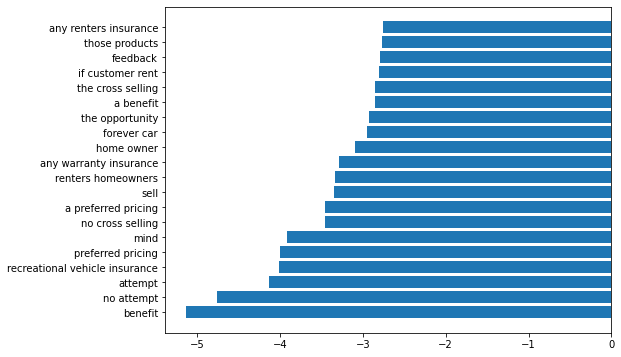

In [226]:
plt.figure(figsize=(8,6))
from matplotlib import pyplot as plt
plt.barh(best_negative_class.values, best_negative_vals)
# plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.show()

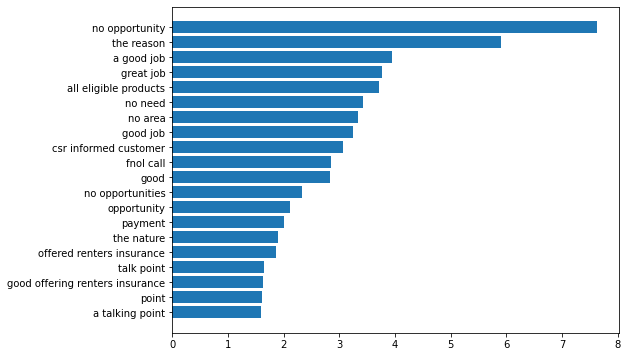

In [227]:
plt.figure(figsize=(8,6))
from matplotlib import pyplot as plt
plt.barh(best_positive_class.values, best_positive_vals)
# plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.show()

## Transcript Noun Phrases

In [51]:
import itertools
texts = [sent_tokenize(text) for text in df['text']]
merged = list(itertools.chain(*texts))

In [52]:
len(texts)

5514

In [337]:
docs = nlp.pipe(merged, n_process=32, batch_size=2048)

In [299]:
from collections import Counter, defaultdict
from torchtext.vocab import Vocab
import numpy
vocab = Vocab(Counter())

In [59]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [76]:
%%time
def get_np_for_tscpt(df):
    tcpt_noun_phrases = pd.Series(index=df.index, dtype='object')
    with nlp.select_pipes(disable=[]):
        for id, text in df.text.iteritems():
            sents = sent_tokenize(text)
            docs = nlp.pipe(sents, batch_size=64)
            nps = [np.text.lower() for doc in docs for np in doc.noun_chunks]
            tcpt_noun_phrases[id] = nps
    return tcpt_noun_phrases

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs


In [77]:
%%time
get_np_for_tscpt(df)

KeyboardInterrupt: 

In [391]:
%%time
top_features = set(top_comments.index)
training_data = numpy.zeros((len(texts), len(top_features)))
with nlp.select_pipes(disable = []):
    for idx, text in enumerate(texts):
        docs = nlp.pipe(text, batch_size = 64)
        mp = defaultdict(int)
        features = [np.text.lower() for doc in docs for np in doc.noun_chunks]
        feature_mp = {feature:None for feature in features}
        feature_vec = [1 if phrase in feature_mp else -1 for phrase in top_features]
        training_data[idx] = feature_vec

CPU times: user 22min 12s, sys: 5.04 s, total: 22min 17s
Wall time: 22min 23s


In [338]:
for com in set(top_comments.index):
    print(com)

rep pitch
any coverages
home owner
no crossselling
all our services
 vehicle
linnell
tip
discount
cross selling
christine
sharonda
 great job
2015 vehicle
the available products
recreational vehicle insurance
payment call
job
the cross
cheryl
the reason
rec vehicles insurance
rentershome owners insurance
no real attempt
a call
no opportunites
homeowners insurance
good offering renters insurance
god
mary
a coaching
vehicle insurance
warranty insurance renters insurance
any recreational vehicles renters
sale agent
ronald
reed
no cross selling
the type
information
service warranty
probed
recreational insurance
good job cross
any other vehicles
any receational vehicles
barb
the payment
coverage
great way
the quote
a benefit
that opportunity
the script
other services
joe
this policy
caller
forever car
benefits
renters insurance recreational vehicles
a billing call
a homeowner
denise
any type
the policy
renters recreational vehicles
if any recreational vehicles
horenters
cutomer
vehicles
bru

In [197]:
training_data.nonzero()

(array([   0,    0,    0, ..., 3771, 3771, 3771]),
 array([ 52, 102, 127, ..., 125, 161, 176]))

In [393]:
X = training_data
y = score_df.loc[df.index]['Cross Selling'].apply(lambda x: int(x/5))

In [394]:
X

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1.,  1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [401]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
lr = LogisticRegression(n_jobs = 8, verbose=1, max_iter=500, solver="saga", class_weight={0:0.75, 1:0.3})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.20026980
Epoch 3, change: 0.10349136
Epoch 4, change: 0.08804186
Epoch 5, change: 0.07300345
Epoch 6, change: 0.05826927
Epoch 7, change: 0.05731815
Epoch 8, change: 0.04992315
Epoch 9, change: 0.04868610
Epoch 10, change: 0.04458947
Epoch 11, change: 0.04026629
Epoch 12, change: 0.03916633
Epoch 13, change: 0.03718415
Epoch 14, change: 0.03417780
Epoch 15, change: 0.03255989
Epoch 16, change: 0.02967122
Epoch 17, change: 0.02791571
Epoch 18, change: 0.02561847
Epoch 19, change: 0.02409797
Epoch 20, change: 0.02203508
Epoch 21, change: 0.02009403
Epoch 22, change: 0.01897297
Epoch 23, change: 0.01768474
Epoch 24, change: 0.01671302
Epoch 25, change: 0.01566483
Epoch 26, change: 0.01463192
Epoch 27, change: 0.01421065
Epoch 28, change: 0.01389449
Epoch 29, change: 0.01340749
Epoch 30, change: 0.01305248
Epoch 31, change: 0.01277390
Epoch 32, change: 0.01246541
Epoch 33, change: 0.01221555
Epoch 34, change: 0.01192555
Epoch 35, change: 0.011

Epoch 52, change: 0.00max_iter reached after 3 seconds
              precision    recall  f1-score   support

           0       0.40      0.56      0.46       313
           1       0.83      0.72      0.77       932

    accuracy                           0.68      1245
   macro avg       0.61      0.64      0.62      1245
weighted avg       0.72      0.68      0.69      1245



/Users/akshaykekuda/miniforge3/envs/attention_m1/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    2.8s finished


In [402]:
scores = lr.coef_.squeeze()

In [403]:
sorted_scores = sorted(enumerate(scores), key = lambda x: x[1])
bottom20 = sorted_scores[:20]
bottom20.reverse()
top20 = sorted_scores[-20:]

In [404]:
top_features = list(top_features)

In [405]:
best_negative_class = [top_features[item[0]] for item in bottom20]
best_positive_class = [top_features[item[0]] for item in top20]
best_negative_vals = [item[1] for item in bottom20]
best_positive_vals = [item[1] for item in top20]

In [406]:
bottom20

[(114, -0.38464334296710767),
 (35, -0.41694822384346275),
 (19, -0.41839422806961),
 (146, -0.42213666251380816),
 (213, -0.4290066804939327),
 (375, -0.4516910703939653),
 (128, -0.45422763073693617),
 (352, -0.46406998950656747),
 (452, -0.48000114255827),
 (359, -0.5027884108596308),
 (345, -0.5063881648277799),
 (148, -0.5189978483246871),
 (92, -0.5280027948116672),
 (323, -0.5482774398030673),
 (338, -0.6006974140633335),
 (125, -0.6168431712614685),
 (10, -0.6433960225120977),
 (235, -0.6442991023339047),
 (394, -0.8402111626280829),
 (458, -0.9324767996975791)]

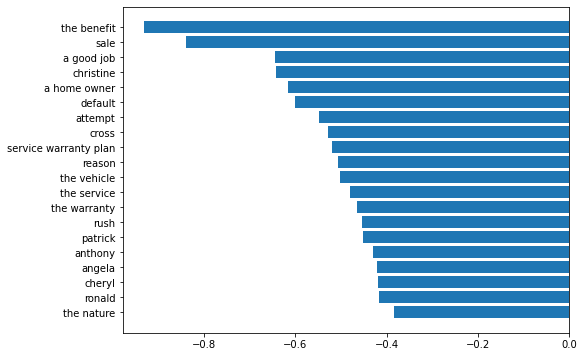

In [407]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))
plt.barh(best_negative_class, best_negative_vals)
# plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.show()

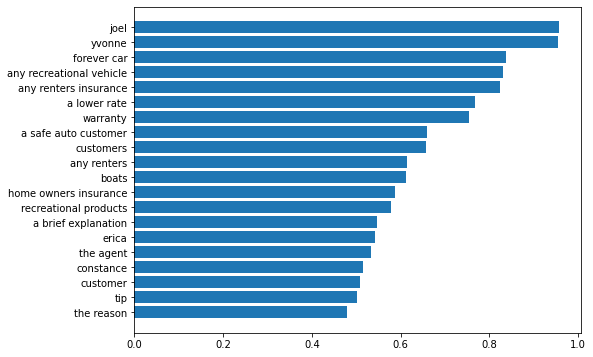

In [408]:
plt.figure(figsize=(8,6))
from matplotlib import pyplot as plt
plt.barh(best_positive_class, best_positive_vals)
# plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.show()

In [384]:
test_df = pd.DataFrame(X_test, columns = top_features)

In [390]:
test_df['home owners insurance'].value_counts()

0.0    1240
1.0       5
Name: home owners insurance, dtype: int64

# SVD Decomposition of comments

In [124]:
from nltk.tokenize import word_tokenize
df['vocab'] = df['csr_text'].apply(lambda x:set(word_tokenize(x)))

In [132]:
prediction = df['vocab'].apply(lambda x: 5*int(any(y in top20_comments for y in x)))

In [135]:
prediction.value_counts()

0    1144
5     384
Name: vocab, dtype: int64

In [142]:
df.loc[df['Cross Selling'] == 3, 'Cross Selling'] = 5
df['Cross Selling'] = df['Cross Selling'].astype('int')

In [146]:
from sklearn.metrics import classification_report
print(classification_report(df['Cross Selling'].values, prediction.values))

              precision    recall  f1-score   support

           0       0.23      0.75      0.36       355
           5       0.77      0.25      0.38      1173

    accuracy                           0.37      1528
   macro avg       0.50      0.50      0.37      1528
weighted avg       0.65      0.37      0.37      1528



In [89]:
n_concepts = 10
concepts = [(lambda x: 'concept{:d}'.format(x))(i+1) for i in range(n_concepts)]
U, Sigma, VT = randomized_svd(Y, n_components=n_concepts)

In [90]:
V_df = pd.DataFrame(
    VT.T,
    index=vectorizer.get_feature_names(),
    columns=concepts
)
V_df

,concept1,concept2,concept3,concept4,concept5,concept6,concept7,concept8,concept9,concept10
2011,0.002921,-0.000110,0.000165,0.006575,-0.000388,0.002518,0.001550,4.227763e-06,0.000450,0.020787
2012,0.002620,-0.000109,0.000134,0.004685,-0.000524,0.004644,-0.003484,5.493505e-06,0.000192,0.018484
2013,0.002098,-0.000044,0.000137,0.004902,0.000292,0.001075,0.005171,2.069153e-06,0.000425,0.018322
2014,0.002318,-0.000065,0.000135,0.004759,0.000204,0.002934,0.003745,3.768378e-06,0.000354,0.017631
2015,0.001454,-0.000061,0.000068,0.002984,-0.000303,0.001503,-0.000884,1.303249e-06,0.000138,0.008595
...,...,...,...,...,...,...,...,...,...,...
woudl,0.000153,0.000013,0.000040,0.000459,0.000209,0.001658,0.000977,1.957395e-06,0.000001,0.004640
yazid,0.002067,-0.000131,0.000049,0.003353,-0.000827,0.002544,-0.004362,-5.408396e-07,-0.000087,0.003081
year,0.000496,0.000070,0.000800,0.001430,0.000760,-0.001225,0.008364,4.717856e-07,0.000345,0.007662
yes,0.000006,0.000005,0.000003,0.000023,0.000191,0.000718,0.000200,3.487296e-07,0.000017,-0.000740


In [91]:
top_term = pd.DataFrame(columns = concepts)
for col in concepts:
    top_term[col] = V_df[col].sort_values(ascending=False)[0:10].index
top_term

,concept1,concept2,concept3,concept4,concept5,concept6,concept7,concept8,concept9,concept10
0,renters,opportunity,sell,vehicles,additional,cross,car,fnol,pitch,customer
1,job,area,reason,good,services,selling,forever,agent,payment,forever
2,recreational,services,cross,insurance,csr,customer,cross,warranty,msi,car
3,homeowners,additional,vehicles,customer,car,sale,selling,vehicle,ni,plan
4,great,sell,customer,car,rep,products,products,plan,car,insurance
5,vehicles,car,billing,forever,opportunity,renter,agent,sale,forever,vehicle
6,good,reason,vehicle,plan,renters,insurance,sale,opportunity,great,rent
7,insurance,cross,changes,additional,great,billing,vehicle,rent,rep,agent
8,customer,selling,status,services,homeowners,asked,renters,reason,policy,homeowners
9,car,vehicle,situation,warranty,customer,great,opportunity,recreational,ad,warranty


In [158]:
[print(comment) for comment in score_comment_df[score_df['Cross Selling'] ==5]['Cross Selling'].sample(10)]

There was no opportunity to offer additional services.
Steven did good job on offering renters insurance, warranty plan and also ask if customer have any recreational vehicles.
There was no area of opportunity to cross sell
no opportunity
we did a good job attempting to cross sell
Not applicable.
Not applicable.
Carla offered recreational vehicles but did not offer Renter's or Home Owner's. Remember to offer all products and discuss benefts.
There was no area of opportunity to cross sell
GREAT JOB BY ASKING FOR RENTERS HOMEOWNERS AND FOR RECREATIONAL VEHICLES AS WELL


[None, None, None, None, None, None, None, None, None, None]

In [159]:
[print(comment) for comment in score_comment_df[score_df['Cross Selling'] ==0]['Cross Selling'].sample(10)]

Good job on offering Renters and checking for Recreational Vehicles, however, we did not let customer know about Forever Car.
None
Did not offer HO/renters, FC, quote with other carriers
No offering or asking of recreational vehicles.
She asked about rec/home own./renters and FC. However did not ask in a conversational manner.
We did not attempt to cross sell on this call.
No Cross Selling of additional products during the call
Merissa did good asking if customer rent or own?but missed to ask if customer have any recreational vehicles to be insured.
tomecia did good job on offering forever car plan and also ask if customer have any recreational vehicles, but missed to offer renters insurance.
we did not attempt to cross sell for any recreational vehicles.


[None, None, None, None, None, None, None, None, None, None]

In [163]:
tf_idf_df[0]

0.000000    794
0.714469      1
0.699667      1
Name: 0, dtype: int64

In [161]:
phrases

,comment,nounphrases
InteractionIdKey,,
100155182230210101,There was no area of opportunity to cross sell,"[no area, opportunity]"
100155356030210101,She asked about rental and recreational,[she]
100155481230210101,Elizabeth did good job on offering HO insuranc...,"[elizabeth, good job, ho insurance, customer, ..."
100156064130210101,Crystal did good job on offering renters insur...,"[crystal, good job, renters insurance, custome..."
100156109530210101,WE DID NOT ASKED FOR RENTERS HOMEOWNERS AND FO...,"[we, renters homeowners]"
...,...,...
300133490550210507,She did offer Forever Car,"[she, car]"
300133595050210507,She offered all cross selling products,"[she, all cross selling products]"
300133775350210507,She didn't have to offer Forever Car due to ve...,"[she, car, vehicle]"


In [164]:
import re

In [173]:
phrases = pd.DataFrame(columns = ['transcript', 'nounphrases'])
phrases['transcript'] = df['csr_text'].dropna()
phrases['nounphrases'] = phrases['transcript'].apply(lambda x:nlp(re.sub('\s+',' ',x)))
phrases['nounphrases'] = phrases['nounphrases'].apply(lambda doc: [np.text.lower() for np in doc.noun_chunks])

In [175]:
vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False, stop_words='english')
vect_representation = vectorizer.fit_transform(phrases['nounphrases'])
X = vect_representation.todense()
tfidf = TfidfTransformer()
Y = tfidf.fit_transform(X).todense()
tf_idf_df = pd.DataFrame(Y.T, index=vectorizer.get_feature_names()) 
top20_comments = tf_idf_df.mean(axis =1).sort_values(ascending=False)[:20]

/Users/akshaykekuda/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [201]:
tf_idf_df

,0,1,2,3,4,5,6,7,8,9,...,21440,21441,21442,21443,21444,21445,21446,21447,21448,21449
customer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
agent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
benefit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
benfit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
boat watercraft,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
your renters insurance proposition,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
your sales call flow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
your sales renters,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yr violations,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
